# TABLE OF CONTENT
+ THE BUSINESS CASE
+ THE DATA
+ THE METHODOLOGY

# THE BUSINESS PROBLEM
According to [Wikipedia](https://en.wikipedia.org/wiki/Types_of_restaurants), you can classify restaurants into seven categories that in turn can be broken down into eleven variations. Some of these combinations might be a little odd (e.g. "Fine Dining" and "Pub") but let us assume for a minute that this list is complete and all combinations are possible. In result, we would have 77 unique combinations of how a restaurant could look like. [Wikipedia](https://en.wikipedia.org/wiki/List_of_cuisines) also hosts a list of cuisines and cuisine types. According to Wikipedia, there are five major cusine styles and 123 distinguished ethnic and religious cuisines, giving us 615  combinations for different types of food that we could eat. If we trust these figures, we are all in all looking at a possible variety of over 43,000 unique restaurants - great, right?
<br>
<br>
![But why](https://media.giphy.com/media/s239QJIh56sRW/giphy.gif)
<br>
<br>
Glad you asked! These figures do not really matter for our problem. I only wanted to show you one thing: The food industry is extremely diverse and each type of restaurant brings its own unique challenges. However, they all have one common issue: Location, location, location! No matter what type of restaurant you own, you need a specific location that matches your profile. Of course you could now say: "That's easy to fix - just go where a lot of people are!" 
<br>
<br>
But is it really so easy? Depending on your restaurant, you need parking space. Maybe you want a quite neighborhood because you own a fine dining restaurant. Maybe you don't want to be where a lot of other restaurants are that are similiar to the cuisine you offer. Or maybe you have a super trendy concept that requires your restaurant to be placed in the most hipster district of your city. We could make this list longer and longer but the point is: It ain't easy. 
<br>
<br>
Choosing the right location also becomes increasingly difficult when you don't know the city you want to open your restaurant in. Finding the right spot will require you to do some extensive research and location scouting. This process takes a lot of time and eats up ressources. While this approach is feasible for small businesses, it becomes unhandy for larger corporations who want to expand their restaurants to multiple cities at the same time. In result, corporations need to spend more money to keep up quality and speed. So how could we help larger restaurant corporations to make this process more efficient? 
<br>
<br>
Well, with data science of course! Larger restaurant chains usually already have a couple of restaurants in place and know which locations run well in their business model and which not. We can use this information to train a clustering algorithm to identify neighborhoods that are similar to the locations with profitable restaurants. This way we can build a recommender system that tells us which neighborhoods in a new town are more likely to host a successful restaurant. Consequently, we would not have to research all areas but could focus our scouting activity on the most promising neighborhoods. This way, we would be able to improve speed and quality as well as cut the related costs significantly.

<br>
<br>

# THE DATA

## L'OSTERIA
As our business problem aims to build a recommender system for a fast growing restaurant chain, we need an example that we can work with. Ladies and gentlemen, please welcome my favorite pizza chain: [L'Osteria](https://losteria.net/en/)!
<br>
<br>
L'Osteria is an italian restaurant chain that was founded in Germany in 1999. The first restaurant was quickly becomming a hit as it combined tasty food, a trendy atmosphere and reasonable prices. Today, the chain has expanded to basically every larger city in Germany and starts to go international with places in Switzerland, Austria, Netherlands and the UK. That gives us a lot of possibilities to train our algorithm. Unfortunately, we do not have access to L'Osteria's database which is why we need to construct our own workaround. Luckily for us, the chain publishes the addresses of all their restaurants on their [website](https://losteria.net/en/restaurants/view/list/?tx_losteriarestaurants_restaurantsreopening%5Bfilter%5D%5Bcountry%5D=de&tx_losteriarestaurants_restaurantsreopening%5Bfilter%5D%5BsearchTerm%5D=&&&tx_losteriarestaurants_restaurantsreopening%5Bfilter%5D%5Btype%5D=reservations&).
<br>
<br>
To use this information, we need to scrape it from their website. When you take a closer look at the L'Osteria website, you will notice that it uses an event button which hides most of the restaurants. We could use a library called [Selenium](https://www.selenium.dev/), if we want a fully automized script that clicks the button for us. However, that would be an overkill as the button only needs to be clicked ~10 times. In result, it is easier to do so by hand and download the website that now shows all restaurants and store it as a html file in our working directory. 
<br>
<br>
That enables us to use the infamous html scraping library [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/). The following code scrapes the data we need from the downloaded html file (also available in the repository) and transforms it as the file contains e.g German characters that otherwise result in jibberish. 

In [180]:
# Import working libraries
import pandas as pd # Data wrangling
from tqdm import tqdm # Progress visualization
import requests # Request handling
from bs4 import BeautifulSoup # HTML search
import re # String handling
import ast # String handling

# Set path to html file
path = r"C:\Users\maurice.buettgenbach\OneDrive - Aquila Capital Management GmbH\Desktop\Desktop\Private\IBM\10_Capstone project\IBM_The_battle_of_neighborhoods_v2\LOSTERIA_DATA\Restaurants - L'Osteria.htm"

# Open document and transform to BS object
with open(path) as page:
    soup = BeautifulSoup(page, 'html.parser')

# Define results
results = soup.find(id='losteria-restaurants-list-wrapper')

# Find elements
page_elements = results.find_all('div', class_='address')

# Create variable to store data in
restaurants = pd.DataFrame()

# Iterate through found elements
for page_element in tqdm(page_elements):
    # Isolate address
    element = str(page_element)
    # Get rid of unnecessary characters
    element = element.replace("\n", "")
    element = element.replace("\r", "")
    # Get rid of spaces
    element = element.replace(" ", "")
    # Search for address in between <div>
    search_result = re.search(">(.*)<", element)
    # Store search result in new variable
    address = search_result.group(1)
    # Get street
    street = address.split(",")[0]
    # Add space between street name and house number
    street = re.sub(r"([0-9]+(\.[0-9]+)?)",r" \1 ", street).strip()
    # Add space before Capital letter
    street = re.sub(r"(?<=\w)([A-Z])", r" \1", street).strip()
    # Get ZIP code and city
    address = address.split(",")[1]
    # Isolate ZIP code
    zip_code = re.split('(\d+)', address)[1]
    # Isolate city
    city = re.split('(\d+)', address)[2]
    # Create temporary df
    temp_df = pd.DataFrame()
    # Add data to df
    temp_df['STREET'] = [street]
    temp_df['ZIP_CODE'] = zip_code
    temp_df['CITY'] = city
    # Append to variable
    restaurants = restaurants.append(temp_df)
# Reset index
restaurants.reset_index(drop=True, inplace=True)

# Replace cryptic html for German characters
restaurants = restaurants.replace('Ã¤', "ae", regex=True) # For German Umlaut "ä"
restaurants = restaurants.replace('Ã¼', "ue", regex=True) # For German Umlaut "ü"
restaurants = restaurants.replace('Ã¶', "oe", regex=True) # For German Umlaut "ö"
restaurants = restaurants.replace('ÃŸ', "ss", regex=True) # For German Umlaut "ß"

# Add spacer for output
print()
print()

# Visualize variable
print("df shape:", restaurants.shape)
restaurants.head(10)

100%|██████████| 121/121 [00:00<00:00, 548.99it/s]



df shape: (121, 3)


,STREET,ZIP_CODE,CITY
0,Gut-Daemme-Strasse 1,52070,Aachen
1,Franziskanergasse 5,92224,Amberg
2,Pearl-S.-Buck-Strasse 12,86156,Augsburg
3,Albert-Schenavsky-Str. 2,86165,Augsburg
4,Maximilianstrasse 83,95444,Bayreuth
5,Hilda-Geiringer-Weg 4,10557,Berlin
6,Alt Mahlsdorf 88,12623,Berlin
7,Memhardstrasse 3,10178,Berlin
8,Mildred-Harnack-Str. 11,10243,Berlin
9,Savignyplatz 5,10623,Berlin


Alright, we have our first dataframe ready! It contains the address of each L'Osteria restaurant from the website, stating their address, ZIP code and city. However, if we want to visualize the restaurants or download information of their surrounding areas, we also need their GPS locations. 
<br>
<br>
Lucky for us, we can reverse engineer the address by using the service of Nominatim that we can access via the [Geopy](https://geopy.readthedocs.io/en/stable/) library. The following code takes our existing addresses and fetches their coordinates from the Nominatim API:

In [149]:
# Import working library
from geopy.geocoders import Nominatim

# Create new variable
lats = []
longs = []

# Set geolocator and set user agent
geolocator = Nominatim(user_agent="german_italian_restaurant_analysis")

# Get temporary df
temp_df = restaurants.copy()

# Loop through df and get addresses for coordinates
for i in tqdm(range(len(temp_df))):
    # Get address
    address = temp_df.iloc[i, 0:1].values[0]
    # Get ZIP code
    zip_code = temp_df.iloc[i, 1:2].values[0]
    # Get city
    city = temp_df.iloc[i, 2:3].values[0]
    # Define full address
    full_address = "{Address}, {ZIPCode}, {City}".format(Address=address, ZIPCode=zip_code, City=city)
    # Get full location details
    location = geolocator.geocode(full_address)
    # Check if location is empty
    if location is not None:
        # Get latitude
        latitude = location.latitude
        # Append latitude
        lats.append(latitude)
    # If empty, add 0
    else:
        # Ste lats to 0
        latitude = 0
        # Append latitude
        lats.append(latitude)
    # Check if location is empty
    if location is not None:
        # Get longitude
        longitude = location.longitude
        # Append longitude
        longs.append(longitude)
    # If empty, add 0
    else:
        longitude = 0
        # Append finding to df
        longs.append(longitude)


# Add longs and lats to restaurant df
restaurants['LATITUDE'] = lats
restaurants['LONGITUDE'] = longs

# Visualize
restaurants.head()

100%|██████████| 121/121 [01:00<00:00,  2.01it/s]


,STREET,ZIP_CODE,CITY,LATITUDE,LONGITUDE
0,Gut-Daemme-Strasse 1,52070,Aachen,50.797335,6.107450
1,Franziskanergasse 5,92224,Amberg,49.446234,11.855468
2,Pearl-S.-Buck-Strasse 12,86156,Augsburg,48.371837,10.865182
3,Albert-Schenavsky-Str. 2,86165,Augsburg,48.381857,10.931547
4,Maximilianstrasse 83,95444,Bayreuth,49.944196,11.571159


As we can see, downloading all GPS coordinates took us ~1 minute. Usually, this would be much faster. However, Nominatim sometimes cannot find the addresses provided which is why we have added a simple if loop in the code above to intercept these cases. Our loop adds a "0" to latitude and longitude when Nominatim cannot find the address. So let us check how many addresses are affected:

In [150]:
# Start counter
counter = 0

# Loop through dataset
for i in tqdm(range(len(restaurants.index))):
    # If 0 in latitude, print street name
    if restaurants.iloc[i, 3:4].values[0] == 0:
        # Print address
        print(restaurants.iloc[i, 0:1].values[0])
        # Add 1 to counter
        counter += 1
    # If large 0
    else:
        # Do nothing
        continue

# Spacer
print() 

# Show counter
print("We are missing coordinates for {counter} restaurants.".format(counter=counter))

# Calculate share of dataset
print("That is {:.2f}% of our dataset.".format(counter/121*100))

100%|██████████| 121/121 [00:00<00:00, 5695.58it/s]

Inder Suerst 3
Bra Wo-Allee 1
Otto-Lillienthal-Strasse 19
Speicherstrasse 1
Hanauer Landstrasse 110
Bleichenbruecke 9
Bruesseler Strasse 14
Ander Untertrave 111
Anden Reeperbahnen 2
Enzian Hoefe
Duesseldorferstrasse 162
Muehlstrasse 17
Am Hafendeck 6 - 8
Ander Vorburg 1

We are missing coordinates for 14 restaurants.
That is 11.57% of our dataset.


We can observe that 14 restaurants have no coordinates. A closer look at the respective addresses shows us that some of them are written wrongly (e.g. "Ander Vorburg 1" should be "An der Vorburg 1"). We could fix these addresses and run our code section again, however, the amount of remaining restaurants with correct coordinates should be more than enough for our analysis. We will therefore exclude restaurants with missing coordinates from our data set:

In [151]:
# Get indexed with lat == 0
index_names = restaurants[(restaurants['LATITUDE'] == 0 )].index

# Kick out entries with lat == 0
restaurants.drop(index_names, inplace=True) 

# Reset index
restaurants.reset_index(drop=True, inplace=True)

# Visualize
print(restaurants.shape)
restaurants.head()

(107, 5)


,STREET,ZIP_CODE,CITY,LATITUDE,LONGITUDE
0,Gut-Daemme-Strasse 1,52070,Aachen,50.797335,6.107450
1,Franziskanergasse 5,92224,Amberg,49.446234,11.855468
2,Pearl-S.-Buck-Strasse 12,86156,Augsburg,48.371837,10.865182
3,Albert-Schenavsky-Str. 2,86165,Augsburg,48.381857,10.931547
4,Maximilianstrasse 83,95444,Bayreuth,49.944196,11.571159


Great! Our L'Osteria data seems to be ready for further analysis. However, before moving on, we will conduct a last check and visualize the GPS coordinates on a map. There are a lot of different ways to visualize geospatial data on a map via Python. For this project, we will use the [Kepler.gl](https://kepler.gl/) tool. It is build on [Mapbox](https://www.mapbox.com/) and can visualize millions of data points as well as has an aggregation function that can be handy for analysis. 

In [152]:
# Load an empty map
from keplergl import KeplerGl
losteria_map = KeplerGl(height=600)

#Load config
config = {'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '73uc1wa', 'type': 'point', 'config': {'dataId': 'losteria_restaurants', 'label': 'LOSTERIA_RESTAURANTS', 'color': [181, 18, 65], 'columns': {'lat': 'LATITUDE', 'lng': 'LONGITUDE', 'altitude': None}, 'isVisible': True, 'visConfig': {'radius': 10, 'fixedRadius': False, 'opacity': 0.5, 'outline': False, 'thickness': 2, 'strokeColor': None, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'radiusRange': [0, 50], 'filled': True}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'strokeColorField': None, 'strokeColorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear'}}], 'interactionConfig': {'tooltip': {'fieldsToShow': {'losteria_restaurants': [{'name': 'STREET', 'format': None}, {'name': 'ZIP_CODE', 'format': None}, {'name': 'CITY', 'format': None}, {'name': 'LATITUDE', 'format': None}, {'name': 'LONGITUDE', 'format': None}]}, 'compareMode': False, 'compareType': 'absolute', 'enabled': True}, 'brush': {'size': 0, 'enabled': False}, 'geocoder': {'enabled': False}, 'coordinate': {'enabled': False}}, 'layerBlending': 'normal', 'splitMaps': [], 'animationConfig': {'currentTime': None, 'speed': 1}}, 'mapState': {'bearing': 0, 'dragRotate': False, 'latitude': 50.489182321984785, 'longitude': 11.880129742841573, 'pitch': 0, 'zoom': 4.289649820829549, 'isSplit': False}, 'mapStyle': {'styleType': 'light', 'topLayerGroups': {}, 'visibleLayerGroups': {'label': True, 'road': True, 'border': True, 'building': True, 'water': True, 'land': True, '3d building': False}, 'threeDBuildingColor': [218.82023004728686, 223.47597962276103, 223.47597962276103], 'mapStyles': {}}}}

# Add data
losteria_map.add_data(data=restaurants, name='losteria_restaurants')

# Add config
losteria_map.config = config

# Execute
losteria_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '73uc1wa', 'type': …

The first thing that catches our eye is that all restaurants seem to be located in Germany. That is odd as we know that the chain has expanded to other European countries already. So what went wrong? After checking the L'Osteria website again, we can see that international restaurants are shown on a different list that we have not downloaded yet. However, as the amount of international restaurants is still small and we should have sufficient data already, we can choose to ignore them for now in order to keep the data set simpler. 
<br>
<br>
Second, we can observe that the majority of restaurants is located in the west and south of Germany. It is especially interesting to see that there is a very high concentration of restaurants in North Rhine Westphalia (the state next to The Netherlands and Belgium). We should keep that in mind during our further analysis as there seems to be something interesting about that region.

## UBER H3 
I was lucky enough to travel a lot in my youth but it is still impossible for me to tell whether a restaurant is located in a trendy neighborhood or not. To draw any conclusions on the neighborhoods the restaurants are located in, I would have to google their locations and research the respective city as a whole. However, L'Osteria has over 120 restaurants in Europe - it would therefore take me days or even weeks to conduct a respective analysis. 
<br>
<br>
Since this is anything else but ressource efficient, we have to find a way of speeding things up. In order to analyse the location of each restaurant, we need to define a radius from which we want to draw conclusions from. One approach would be to get shapefiles for each neighborhood in each city L'Osteria has a restaurant in and then download information related to these neigborhoods. But good luck trying to get these shapefile for Germany. Here, every state has its own data service - one more confusing than the other. Collecting the necessary data would take weeks and provide us with a minimal granularity.
<br>
<br>
This is where Uber's H3 hexagonial mapping framework comes in play. At its core, H3 is a geospatial analysis tool that provides a global index of hirachically ordered hexagons. Just imagine that you would map the entire earth (pole to pole) in hexagonial polygons. Now, each hexagon would receive a unique ID so that you could exactly tell what place on earth belongs to which hexagon. And finally, think of different layers of hexagons. Each layer is much smaller and more precise, enabling you to drill up and down on your map. That is exactly what H3 does - it provides you unique hexagons with different resolutions, all the way down to a precision of 0.0000009 km² area. 
<br>
<br>
So how is this helping us? By knowing the GPS coordinates of the L'Osteria restaurants, we can assign them to an unique hexagon. This hexagon will then serve as our designated radius for which we will download further data for our analysis. The H3 framework also helps us to map any city on earth with the same size of hexagons, making it easier for us to compare our results. 
<br>
<br>
But enough of the chit-chat! Let us begin with mapping the coordinates of our L'Osteria restaurants against the H3 index. To do so, we can simply use the [H3 library](https://github.com/uber/h3-py). The library provides a function that does the mapping for us. However, besides providing the coordinates, we also need to define the resolution of the hexagon we want to map with. The H3 index has 16 unique [resolutions](https://h3geo.org/docs/core-library/restable/) that we can choose from:

In [153]:
# Import working library
import ssl

# Reset certifications
ssl._create_default_https_context = ssl._create_unverified_context

# Fetch table from H3 geo website
h3_resolution_table = pd.read_html('https://h3geo.org/docs/core-library/restable/')

# Visualize
h3_resolution_table[0]

,H3 Resolution,Average Hexagon Area (km2),Average Hexagon Edge Length (km),Number of unique indexes
0,0,4.250547e+06,1107.712591,122
1,1,6.072210e+05,418.676005,842
2,2,8.674585e+04,158.244656,5882
3,3,1.239226e+04,59.810858,41162
4,4,1.770324e+03,22.606379,288122
5,5,2.529034e+02,8.544408,2016842
6,6,3.612905e+01,3.229483,14117882
7,7,5.161293e+00,1.220630,98825162
8,8,7.373276e-01,0.461355,691776122
9,9,1.053325e-01,0.174376,4842432842


As described above, the resolution goes all the way down to 0.0000009 km² or 0.9 m² respectively. That is extremely small and would not serve our purpose well as we aim to analyze larger areas around our restaurants. By looking at a map, we can visually see that the H3 resolution 7 with an area of roughly 5km² could be a good fit as it should cover the restaurants' general catchment area. 
<br>
<br>
In the following step, we will download the unique hexagons for each restaurant and visualize them on our kepler map:

In [154]:
# Import working directories
import h3

# Creat empty variable
h3_indexes = []

# Download H3 indexes
for i in tqdm(range(len(restaurants.index))):
    # Get lat
    lat = restaurants.iloc[i, 3:4][0]
    # Get lng
    lng = restaurants.iloc[i, 4:5][0]
    # Get H3 index
    h3_index = h3.geo_to_h3(
        lat=lat,
        lng=lng,
        resolution=7
    )
    # Store in variable
    h3_indexes.append(h3_index)

# Store in restaurants variable
restaurants['H3_INDEX'] = h3_indexes

# Visualize
from keplergl import KeplerGl
losteria_map_v2 = KeplerGl(height=600)
config = {'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 've9o5ju', 'type': 'hexagonId', 'config': {'dataId': 'losteria_restaurants', 'label': 'LOSTERIA_RESTAURANTS_HEXAGONS', 'color': [249, 196, 196], 'columns': {'hex_id': 'H3_INDEX'}, 'isVisible': True, 'visConfig': {'opacity': 0.5, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'coverage': 1, 'enable3d': False, 'sizeRange': [0, 500], 'coverageRange': [0, 1], 'elevationScale': 5, 'enableElevationZoomFactor': True}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'coverageField': None, 'coverageScale': 'linear'}}, {'id': '73uc1wa', 'type': 'point', 'config': {'dataId': 'losteria_restaurants', 'label': 'LOSTERIA_RESTAURANTS', 'color': [181, 18, 65], 'columns': {'lat': 'LATITUDE', 'lng': 'LONGITUDE', 'altitude': None}, 'isVisible': True, 'visConfig': {'radius': 10, 'fixedRadius': False, 'opacity': 0.5, 'outline': False, 'thickness': 2, 'strokeColor': None, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'radiusRange': [0, 50], 'filled': True}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'strokeColorField': None, 'strokeColorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear'}}], 'interactionConfig': {'tooltip': {'fieldsToShow': {'losteria_restaurants': [{'name': 'STREET', 'format': None}, {'name': 'ZIP_CODE', 'format': None}, {'name': 'CITY', 'format': None}, {'name': 'LATITUDE', 'format': None}, {'name': 'LONGITUDE', 'format': None}]}, 'compareMode': False, 'compareType': 'absolute', 'enabled': True}, 'brush': {'size': 0, 'enabled': False}, 'geocoder': {'enabled': False}, 'coordinate': {'enabled': False}}, 'layerBlending': 'normal', 'splitMaps': [], 'animationConfig': {'currentTime': None, 'speed': 1}}, 'mapState': {'bearing': 0, 'dragRotate': False, 'latitude': 53.56581943999632, 'longitude': 9.954395594799491, 'pitch': 0, 'zoom': 11.223547206164303, 'isSplit': False}, 'mapStyle': {'styleType': 'light', 'topLayerGroups': {}, 'visibleLayerGroups': {'label': True, 'road': True, 'border': True, 'building': True, 'water': True, 'land': True, '3d building': False}, 'threeDBuildingColor': [218.82023004728686, 223.47597962276103, 223.47597962276103], 'mapStyles': {}}}}
losteria_map_v2.add_data(data=restaurants, name='losteria_restaurants') # refresh data
losteria_map_v2.config = config # refresh config
losteria_map_v2 # execute

100%|██████████| 107/107 [00:00<00:00, 2820.99it/s]

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 've9o5ju', 'type': …

When we zoom in (e.g. to the city of Hamburg), we can observe that we have successfully added the hexagons to our restaurants' locations. However, we can see that the hexagons are not centered around our restaurants' locations and thus cover large areas that probably do not account as the restaurants't catchment areas. To fix this issue, we will step down in our resolution and check again:

In [155]:
# Import working directories
import h3

# Creat empty variable
h3_indexes = []

# Download H3 indexes
for i in tqdm(range(len(restaurants.index))):
    # Get lat
    lat = restaurants.iloc[i, 3:4][0]
    # Get lng
    lng = restaurants.iloc[i, 4:5][0]
    # Get H3 index
    h3_index = h3.geo_to_h3(
        lat=lat,
        lng=lng,
        resolution=9
    )
    # Store in variable
    h3_indexes.append(h3_index)

# Store in restaurants variable
restaurants['H3_INDEX'] = h3_indexes

# Visualize
from keplergl import KeplerGl
losteria_map_v3 = KeplerGl(height=600)
config = {'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 've9o5ju', 'type': 'hexagonId', 'config': {'dataId': 'losteria_restaurants', 'label': 'LOSTERIA_RESTAURANTS_HEXAGONS', 'color': [249, 196, 196], 'columns': {'hex_id': 'H3_INDEX'}, 'isVisible': True, 'visConfig': {'opacity': 0.5, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'coverage': 1, 'enable3d': False, 'sizeRange': [0, 500], 'coverageRange': [0, 1], 'elevationScale': 5, 'enableElevationZoomFactor': True}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'coverageField': None, 'coverageScale': 'linear'}}, {'id': '73uc1wa', 'type': 'point', 'config': {'dataId': 'losteria_restaurants', 'label': 'LOSTERIA_RESTAURANTS', 'color': [181, 18, 65], 'columns': {'lat': 'LATITUDE', 'lng': 'LONGITUDE', 'altitude': None}, 'isVisible': True, 'visConfig': {'radius': 10, 'fixedRadius': False, 'opacity': 0.5, 'outline': False, 'thickness': 2, 'strokeColor': None, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'radiusRange': [0, 50], 'filled': True}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'strokeColorField': None, 'strokeColorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear'}}], 'interactionConfig': {'tooltip': {'fieldsToShow': {'losteria_restaurants': [{'name': 'STREET', 'format': None}, {'name': 'ZIP_CODE', 'format': None}, {'name': 'CITY', 'format': None}, {'name': 'LATITUDE', 'format': None}, {'name': 'LONGITUDE', 'format': None}]}, 'compareMode': False, 'compareType': 'absolute', 'enabled': True}, 'brush': {'size': 0, 'enabled': False}, 'geocoder': {'enabled': False}, 'coordinate': {'enabled': False}}, 'layerBlending': 'normal', 'splitMaps': [], 'animationConfig': {'currentTime': None, 'speed': 1}}, 'mapState': {'bearing': 0, 'dragRotate': False, 'latitude': 53.56581943999632, 'longitude': 9.954395594799491, 'pitch': 0, 'zoom': 11.223547206164303, 'isSplit': False}, 'mapStyle': {'styleType': 'light', 'topLayerGroups': {}, 'visibleLayerGroups': {'label': True, 'road': True, 'border': True, 'building': True, 'water': True, 'land': True, '3d building': False}, 'threeDBuildingColor': [218.82023004728686, 223.47597962276103, 223.47597962276103], 'mapStyles': {}}}}
losteria_map_v3.add_data(data=restaurants, name='losteria_restaurants') # refresh data
losteria_map_v3.config = config # refresh config
losteria_map_v3 # execute

100%|██████████| 107/107 [00:00<00:00, 2682.18it/s]

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 've9o5ju', 'type': …

We have now used resolution 9 which is covering an area of a little bit more than 0.1km². We can observe that the hexagons are now lying much closer to our locations. However, we still have the problem that the hexagons' centers are far away from our restaurants' locations. We now also have the problem that they cover a much smaller area that would give us less information and might poorly reflect the catchment area of our restaurants. To counter these issues, we will download the hexagons' neighbours and assign them to our data frame. This way we will expand our search radius.

In [156]:
# Degree of neighbouring hexagons
k_neighbours = 2

# Creat empty variable
h3_indexes = pd.DataFrame()

# Get neighbours per hexagon
for i in tqdm(range(len(restaurants.index))):
    # Get H3 index
    h3_index = restaurants.iloc[i, 5:6][0]
    # Get neighbouring hexagon indexes
    h3_neighbours = h3.k_ring(h3_index, k_neighbours)
    # Convert to df
    h3_neighbours = pd.DataFrame(h3_neighbours)
    # Get restaurant information
    street = restaurants.iloc[i, 0:1][0]
    zip_code = restaurants.iloc[i, 1:2][0]
    city = restaurants.iloc[i, 2:3][0]
    lat = restaurants.iloc[i, 3:4][0]
    lng = restaurants.iloc[i, 4:5][0]
    # Store in df
    h3_neighbours['STREET'] = street
    h3_neighbours['ZIP_CODE'] = zip_code
    h3_neighbours['CITY'] = city
    h3_neighbours['LATITUDE'] = lat
    h3_neighbours['LONGITUDE'] = lng
    # Append empty variable
    h3_indexes = h3_indexes.append(h3_neighbours)

# Rename column
h3_indexes.rename(columns={0:'H3_INDEX'}, inplace=True)

# Reset index
h3_indexes.reset_index(drop=True, inplace=True)

# Merge with restaurants variable
restaurants_hexagons = restaurants.merge(h3_indexes, how='right', on=['STREET','ZIP_CODE', 'CITY', 'LATITUDE', 'LONGITUDE', 'H3_INDEX'])

# Visualize
from keplergl import KeplerGl
losteria_map_v4 = KeplerGl(height=600)
config = {'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '73uc1wa', 'type': 'point', 'config': {'dataId': 'losteria_restaurants', 'label': 'LOSTERIA_RESTAURANTS', 'color': [181, 18, 65], 'columns': {'lat': 'LATITUDE', 'lng': 'LONGITUDE', 'altitude': None}, 'isVisible': True, 'visConfig': {'radius': 10, 'fixedRadius': False, 'opacity': 0.5, 'outline': False, 'thickness': 2, 'strokeColor': None, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'radiusRange': [0, 50], 'filled': True}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'strokeColorField': None, 'strokeColorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear'}}, {'id': '1fxg53d', 'type': 'hexagonId', 'config': {'dataId': 'losteria_restaurants_hexagons', 'label': 'LOSTERIA_RESTAURANTS_HEXAGONS', 'color': [249, 196, 196], 'columns': {'hex_id': 'H3_INDEX'}, 'isVisible': True, 'visConfig': {'opacity': 0.5, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'coverage': 1, 'enable3d': False, 'sizeRange': [0, 500], 'coverageRange': [0, 1], 'elevationScale': 5, 'enableElevationZoomFactor': True}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'coverageField': None, 'coverageScale': 'linear'}}], 'interactionConfig': {'tooltip': {'fieldsToShow': {'losteria_restaurants': [{'name': 'STREET', 'format': None}, {'name': 'ZIP_CODE', 'format': None}, {'name': 'CITY', 'format': None}, {'name': 'LATITUDE', 'format': None}, {'name': 'LONGITUDE', 'format': None}], 'losteria_restaurants_hexagons': [{'name': 'STREET', 'format': None}, {'name': 'ZIP_CODE', 'format': None}, {'name': 'CITY', 'format': None}, {'name': 'LATITUDE', 'format': None}, {'name': 'LONGITUDE', 'format': None}]}, 'compareMode': False, 'compareType': 'absolute', 'enabled': True}, 'brush': {'size': 0, 'enabled': False}, 'geocoder': {'enabled': False}, 'coordinate': {'enabled': False}}, 'layerBlending': 'normal', 'splitMaps': [], 'animationConfig': {'currentTime': None, 'speed': 1}}, 'mapState': {'bearing': 0, 'dragRotate': False, 'latitude': 53.56581943999632, 'longitude': 9.954395594799491, 'pitch': 0, 'zoom': 11.223547206164303, 'isSplit': False}, 'mapStyle': {'styleType': 'light', 'topLayerGroups': {}, 'visibleLayerGroups': {'label': True, 'road': True, 'border': True, 'building': True, 'water': True, 'land': True, '3d building': False}, 'threeDBuildingColor': [218.82023004728686, 223.47597962276103, 223.47597962276103], 'mapStyles': {}}}}
losteria_map_v4.add_data(data=restaurants, name='losteria_restaurants') # refresh data
losteria_map_v4.add_data(data=restaurants_hexagons, name='losteria_restaurants_hexagons') # new data
losteria_map_v4.config = config # refresh config
losteria_map_v4 # execute

100%|██████████| 107/107 [00:00<00:00, 308.93it/s]


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '73uc1wa', 'type': …

So what happened now? We added neighbouring hexagons of the degree 2 or in other words, we added our initial hexagons' neighbours and their neighbours. In result, we receive a much larger area that a) moves our restaurants'locations more towards the centre of our hexagonial area and b) expands the hexagons to reflect a larger catchment area. With this our H3 data set should be ready and we can move to the next step!

## OPEN STREET MAP
We can now analyze the area of our L'Osteria locations by downloading the information linked to the initial as well as neighbouring hexagons. However, if we want to analyze a specific area such as a city, we cannot use this approach straight forward since we are limited to borders that are not considered under H3. The closer we get to the borders of a city, the more hexagons we would observe that are located outside of the city's borders. Hence, our data could be distorted. So what do we do?
<br>
<br>
We need shape files. A shape file is a specific data format that allows you to handle geospatial data. In our case, we are specifically interested in shapefiles that contain border information of European cities. There are many data providers that offer this information in form of a shape file. Since we are on a budget, we will use the shape files provided by [OpenStreetMap](https://www.openstreetmap.de/). OpenStreetMap is an international project founded in 2004 with the goal of creating a free map of the world. For this purpose they collect data about roads, railroads, rivers, forests, houses and much more worldwide. However, the shapefiles we are interested in are provided by [Geofabrik](https://www.geofabrik.de/) which is a German provider who built its service based on OpenStreetMap. Here, you can download shapefiles of various countries, regions and cities for free.
<br>
<br>
L'Osteria has recently started adding locations in the UK to their portfolio. However, so far there has been no new restaurant in London itself. So guess what we will do - right, we are going to analyse where in London would be a potentially good location for a new L'Osteria restaurant! 
<br>
<br>
So in the first step, we are going to download the necessary shape file from Geofabrik. You can do so via this [link](https://download.geofabrik.de/europe/great-britain/england/greater-london.html). After the download, the file needs to be extracted within the working directory. It then can be read via the [Geopandas](https://geopandas.org/) library. The shapefile we are interested in is called "gis_osm_places_a_free_1.shp" and contains multiple shapes of the city of London in form of polygons. Since we are not interested in multiple different shapes that cluster London, we need to select the right shape with the name "London":

In [157]:
# Import working libraries
import geopandas as gpd

# Set path
path = r'C:\Users\maurice.buettgenbach\OneDrive - Aquila Capital Management GmbH\Desktop\Desktop\Private\IBM\10_Capstone project\IBM_The_battle_of_neighborhoods_v2\LONDON_SHAPE_FILES\gis_osm_places_a_free_1.shp'

# Read file
london_shape = gpd.read_file(path)

# Isolate city polygon
london_shape = london_shape[(london_shape['name'] == 'London')]

# Visualize
from keplergl import KeplerGl
london_map_v1 = KeplerGl(height=600)
config = {'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'ci1qt6n', 'type': 'geojson', 'config': {'dataId': 'london_shape_file', 'label': 'London', 'color': [179, 173, 158], 'columns': {'geojson': 'geometry'}, 'isVisible': True, 'visConfig': {'opacity': 0.8, 'strokeOpacity': 0.8, 'thickness': 2, 'strokeColor': [192, 192, 192], 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 1, 'enableElevationZoomFactor': True, 'stroked': True, 'filled': False, 'enable3d': False, 'wireframe': False}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'strokeColorField': None, 'strokeColorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}], 'interactionConfig': {'tooltip': {'fieldsToShow': {'losteria_restaurants': [{'name': 'STREET', 'format': None}, {'name': 'ZIP_CODE', 'format': None}, {'name': 'CITY', 'format': None}, {'name': 'LATITUDE', 'format': None}, {'name': 'LONGITUDE', 'format': None}], 'losteria_restaurants_hexagons': [{'name': 'STREET', 'format': None}, {'name': 'ZIP_CODE', 'format': None}, {'name': 'CITY', 'format': None}, {'name': 'LATITUDE', 'format': None}, {'name': 'LONGITUDE', 'format': None}], 'london_shape_file': [{'name': 'osm_id', 'format': None}, {'name': 'code', 'format': None}, {'name': 'fclass', 'format': None}, {'name': 'name', 'format': None}]}, 'compareMode': False, 'compareType': 'absolute', 'enabled': True}, 'brush': {'size': 0, 'enabled': False}, 'geocoder': {'enabled': False}, 'coordinate': {'enabled': False}}, 'layerBlending': 'normal', 'splitMaps': [], 'animationConfig': {'currentTime': None, 'speed': 1}}, 'mapState': {'bearing': 0, 'dragRotate': False, 'latitude': 51.54868482103512, 'longitude': -0.054559532218202485, 'pitch': 0, 'zoom': 9.579370455413446, 'isSplit': False}, 'mapStyle': {'styleType': 'light', 'topLayerGroups': {}, 'visibleLayerGroups': {'label': True, 'road': True, 'border': True, 'building': True, 'water': True, 'land': True, '3d building': False}, 'threeDBuildingColor': [218.82023004728686, 223.47597962276103, 223.47597962276103], 'mapStyles': {}}}}
london_map_v1.add_data(data=london_shape, name='london_shape_file')
london_map_v1.config = config # refresh config
london_map_v1 # execute

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'ci1qt6n', 'type': …

We can observe that our approach was successful - with the exception that the city centre is missing a piece. The shape seems to be excluding the district "City of London". The documentation of Geofabrik says that all "city" shapes follow official boundaries. A quick research shows that the City of London has a different politcal status than the rest of London and hence is treated as its own "city in the city". It is therefore not covered by the shapefile. 
<br>
<br>
Since we want to cover the entire city, we need to find a solution on how to eliminate the donut hole in our polygon. Good thing that there is stackoverflow! Someone apparently already had this problem, so we will use [this code](https://stackoverflow.com/questions/61427797/filling-a-hole-in-a-multipolygon-with-shapely-netherlands-2-digit-postal-codes) and amend it to our variables:

In [158]:
# Import working libraries
from shapely.geometry import Polygon

# Define function
def close_holes(poly: Polygon) -> Polygon:
        """
        Close polygon holes by limitation to the exterior ring.
        Args:
            poly: Input shapely Polygon
        Example:
            df.geometry.apply(lambda p: close_holes(p))
        """
        if poly.interiors:
            return Polygon(list(poly.exterior.coords))
        else:
            return poly

# Apply function
london_shape = london_shape.geometry.apply(lambda p: close_holes(p))

# Convert to geopandas df
london_shape = gpd.GeoDataFrame(london_shape)

# Copy for later mapping
london_border = london_shape.copy() # copy

# Visualize
from keplergl import KeplerGl
london_map_v2 = KeplerGl(height=600)
config = {'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'ci1qt6n', 'type': 'geojson', 'config': {'dataId': 'london_shape_file', 'label': 'London', 'color': [179, 173, 158], 'columns': {'geojson': 'geometry'}, 'isVisible': True, 'visConfig': {'opacity': 0.8, 'strokeOpacity': 0.8, 'thickness': 2, 'strokeColor': [192, 192, 192], 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 1, 'enableElevationZoomFactor': True, 'stroked': True, 'filled': False, 'enable3d': False, 'wireframe': False}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'strokeColorField': None, 'strokeColorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}], 'interactionConfig': {'tooltip': {'fieldsToShow': {'losteria_restaurants': [{'name': 'STREET', 'format': None}, {'name': 'ZIP_CODE', 'format': None}, {'name': 'CITY', 'format': None}, {'name': 'LATITUDE', 'format': None}, {'name': 'LONGITUDE', 'format': None}], 'losteria_restaurants_hexagons': [{'name': 'STREET', 'format': None}, {'name': 'ZIP_CODE', 'format': None}, {'name': 'CITY', 'format': None}, {'name': 'LATITUDE', 'format': None}, {'name': 'LONGITUDE', 'format': None}], 'london_shape_file': [{'name': 'osm_id', 'format': None}, {'name': 'code', 'format': None}, {'name': 'fclass', 'format': None}, {'name': 'name', 'format': None}]}, 'compareMode': False, 'compareType': 'absolute', 'enabled': True}, 'brush': {'size': 0, 'enabled': False}, 'geocoder': {'enabled': False}, 'coordinate': {'enabled': False}}, 'layerBlending': 'normal', 'splitMaps': [], 'animationConfig': {'currentTime': None, 'speed': 1}}, 'mapState': {'bearing': 0, 'dragRotate': False, 'latitude': 51.54868482103512, 'longitude': -0.054559532218202485, 'pitch': 0, 'zoom': 9.579370455413446, 'isSplit': False}, 'mapStyle': {'styleType': 'light', 'topLayerGroups': {}, 'visibleLayerGroups': {'label': True, 'road': True, 'border': True, 'building': True, 'water': True, 'land': True, '3d building': False}, 'threeDBuildingColor': [218.82023004728686, 223.47597962276103, 223.47597962276103], 'mapStyles': {}}}}
london_map_v2.add_data(data=london_shape, name='london_shape_file')
london_map_v2.config = config # refresh config
london_map_v2 # execute

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'ci1qt6n', 'type': …

Now that we have one shape covering entire London, we can begin the download the H3 hexagons for London. We will do so by using the "polyfill" function of the H3 python library. This function will "fill up" our shape with unique hexagons until the shape is completely covered:

In [159]:
# Convert to json
london_geojson = london_shape.to_json()

# Convert do dict
london_geojson = pd.read_json(london_geojson)

# Isolate polygon
london_poly = london_geojson['features'][0]['geometry'].copy() 

# Set resolution
resolution = 9

# Get h3 indexes
london_h3_hex = h3.polyfill_geojson(london_poly, resolution) 

# Convert to pandas df
london_h3_hex = pd.DataFrame(london_h3_hex)

# Show df shape
print(london_h3_hex.shape)

# Visualize
from keplergl import KeplerGl
london_map_v3 = KeplerGl(height=600)
config = {'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'ci1qt6n', 'type': 'geojson', 'config': {'dataId': 'london_shape_file', 'label': 'LONDON_BORDER', 'color': [179, 173, 158], 'columns': {'geojson': 'geometry'}, 'isVisible': True, 'visConfig': {'opacity': 0.8, 'strokeOpacity': 0.8, 'thickness': 2, 'strokeColor': [192, 192, 192], 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 1, 'enableElevationZoomFactor': True, 'stroked': True, 'filled': False, 'enable3d': False, 'wireframe': False}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'strokeColorField': None, 'strokeColorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}, {'id': 'akq9on', 'type': 'hexagonId', 'config': {'dataId': 'london_h3_hexagons', 'label': 'LONDON_H3_RES_9', 'color': [47, 197, 204], 'columns': {'hex_id': 'column_0'}, 'isVisible': True, 'visConfig': {'opacity': 0.05, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'coverage': 1, 'enable3d': False, 'sizeRange': [0, 500], 'coverageRange': [0, 1], 'elevationScale': 5, 'enableElevationZoomFactor': True}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'coverageField': None, 'coverageScale': 'linear'}}], 'interactionConfig': {'tooltip': {'fieldsToShow': {'london_shape_file': [], 'london_h3_hexagons': [{'name': 'column_0', 'format': None}]}, 'compareMode': False, 'compareType': 'absolute', 'enabled': True}, 'brush': {'size': 0, 'enabled': False}, 'geocoder': {'enabled': False}, 'coordinate': {'enabled': False}}, 'layerBlending': 'normal', 'splitMaps': [], 'animationConfig': {'currentTime': None, 'speed': 1}}, 'mapState': {'bearing': 0, 'dragRotate': False, 'latitude': 51.49025098481283, 'longitude': -0.11004399497071785, 'pitch': 0, 'zoom': 9.031311538496494, 'isSplit': False}, 'mapStyle': {'styleType': 'light', 'topLayerGroups': {}, 'visibleLayerGroups': {'label': True, 'road': True, 'border': True, 'building': True, 'water': True, 'land': True, '3d building': False}, 'threeDBuildingColor': [218.82023004728686, 223.47597962276103, 223.47597962276103], 'mapStyles': {}}}}
london_map_v3.add_data(data=london_border, name='london_shape_file')
london_map_v3.add_data(data=london_h3_hex, name='london_h3_hexagons')
london_map_v3.config = config # refresh config
london_map_v3 # execute

(16890, 1)
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'ci1qt6n', 'type': …

In result, our London shape has been filled up with a total of 16,890 unique hexagons with the resolution 9. When you scroll in and have a closer look at the shape's border, you will see that the hexagons are sometimes overlapping the border or that some hexagons are missing. This is correct since the polyfill function excludes hexagons whose majority does not lie within the given shape. In result, the H3 mapping approach is getting imprecise around a shape's border. However, for our purpose this is negligible as we are going to add a few more hexagons to simulate catchment areas. To do that, we can simply recycle our code from above:

In [160]:
# Degree of neighbouring hexagons
k_neighbours = 2

# Creat empty variable
h3_indexes = pd.DataFrame()

# Get neighbours per hexagon
for i in tqdm(range(len(london_h3_hex.index))):
    # Get H3 index
    h3_index = london_h3_hex.iloc[i, 0:1][0]
    # Get neighbouring hexagon indexes
    h3_neighbours = h3.k_ring(h3_index, k_neighbours)
    # Convert to df
    h3_neighbours = pd.DataFrame(h3_neighbours)
    # Store initial hexagon in df
    h3_neighbours['INITIAL_HEXAGON'] = h3_index
    # Append empty variable
    h3_indexes = h3_indexes.append(h3_neighbours)

# Rename column
h3_indexes.rename(columns={0:'H3_INDEX'}, inplace=True)

# Reset index
h3_indexes.reset_index(drop=True, inplace=True)

# Update variable
london_h3_hex = h3_indexes

# Isolate unique hexagons for download and mapping
london_h3_hex_unique = pd.DataFrame(london_h3_hex['H3_INDEX'].unique())

# Refresh border data
london_border = pd.DataFrame(london_border) # convert to df

# Visualize shape
print(london_h3_hex.shape)
# Visualize kepler map
from keplergl import KeplerGl
london_map_v4 = KeplerGl(height=600)
config = {'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'ci1qt6n', 'type': 'geojson', 'config': {'dataId': 'london_shape_file', 'label': 'LONDON_BORDER', 'color': [179, 173, 158], 'columns': {'geojson': 'geometry'}, 'isVisible': True, 'visConfig': {'opacity': 0.8, 'strokeOpacity': 0.8, 'thickness': 2, 'strokeColor': [192, 192, 192], 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 1, 'enableElevationZoomFactor': True, 'stroked': True, 'filled': False, 'enable3d': False, 'wireframe': False}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'strokeColorField': None, 'strokeColorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}, {'id': 'akq9on', 'type': 'hexagonId', 'config': {'dataId': 'london_h3_hexagons', 'label': 'LONDON_H3_RES_9', 'color': [47, 197, 204], 'columns': {'hex_id': 'column_0'}, 'isVisible': True, 'visConfig': {'opacity': 0.05, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'coverage': 1, 'enable3d': False, 'sizeRange': [0, 500], 'coverageRange': [0, 1], 'elevationScale': 5, 'enableElevationZoomFactor': True}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'coverageField': None, 'coverageScale': 'linear'}}], 'interactionConfig': {'tooltip': {'fieldsToShow': {'london_shape_file': [], 'london_h3_hexagons': [{'name': 'column_0', 'format': None}]}, 'compareMode': False, 'compareType': 'absolute', 'enabled': True}, 'brush': {'size': 0, 'enabled': False}, 'geocoder': {'enabled': False}, 'coordinate': {'enabled': False}}, 'layerBlending': 'normal', 'splitMaps': [], 'animationConfig': {'currentTime': None, 'speed': 1}}, 'mapState': {'bearing': 0, 'dragRotate': False, 'latitude': 51.49025098481283, 'longitude': -0.11004399497071785, 'pitch': 0, 'zoom': 9.031311538496494, 'isSplit': False}, 'mapStyle': {'styleType': 'light', 'topLayerGroups': {}, 'visibleLayerGroups': {'label': True, 'road': True, 'border': True, 'building': True, 'water': True, 'land': True, '3d building': False}, 'threeDBuildingColor': [218.82023004728686, 223.47597962276103, 223.47597962276103], 'mapStyles': {}}}}
london_map_v4.add_data(data=london_border, name='london_shape_file')
london_map_v4.add_data(data=london_h3_hex_unique, name='london_h3_hexagons')
london_map_v4.config = config # refresh config
london_map_v4 # execute

100%|██████████| 16890/16890 [01:31<00:00, 185.50it/s]


(320910, 2)
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'ci1qt6n', 'type': …

Alright, what happened? In the first step, we have assigned all of the hexagons in our London shape their neighbouring hexagons with a degree of two. In result, we received a much larger df. Is that right? Yes, it is because each unique hexagon is also included as a neighbour of another unique hexagon. We therefore have a lot of overlapping catchment areas and hence a much larger dataframe. 
<br>
<br>
In the second step, we have isolated the unique hexagons from our larger df. The result can be seen on the map above: We now have hexagons that are outside of our shape. These hexagons have been added because they are degree two neighbours of the hexagons located close to the shape's borders. This way we were able to solve the issue that some hexagons were excluded by the polyfill function without loosing the initial shape's appearance. 
<br>
<br>
We are now ready to make the next step: Adding actual data!

## FOURSQUARE
To add data to our hexagons, we will use [Foursquare](https://foursquare.com/) which is an app that lets its users rank all different kinds of venues all over the world. By doing so, Foursquare has build one of the most comprehensive geospatial data sets in the world. The data set covers an extremely large amount of venue and user data that allows you to access everything from a venue's name, location or menu up to user ratings, comments or pictures of each venue. And the best part: Foursquare provides developers an [API](https://developer.foursquare.com/) that is (in limits) free to use! 
<br>
<br>
Even though Foursquare provides an incredible variety of data, we will use the venue categories (e.g. sushi restaurant, park, sports club, italian restaurant, etc.) for our analysis only. While it would most likely increase the success of our algorithm to include more information such as rankings or types of user data, we will not include this data due to ressource limitations.
<br>
<br>
We will use the Foursquare data to analyze the area of the hexagons (or neighbouring hexagons) in which L'Osteria has existing restaurants as well as the hexagons of the new city we are interested in. This way we will be able to cluster the hexagons according to their characteristics.
<br>
<br>
Ok, let's start with the basics: Adding our user data! However, I will not include my user credentials in the code due to privacy issues. Instead, I will load them from a txt file I have prepared. The textfile is not stored on the repository. So if you want to replicate my steps, you would have to do create your own txt files and load your credentials seperately.

In [161]:
# Set credentials
client_id = list(pd.read_csv(r'C:\Users\maurice.buettgenbach\OneDrive - Aquila Capital Management GmbH\Desktop\Desktop\Private\IBM\10_Capstone project\IBM_The_battle_of_neighborhoods_v2\FOURSQUARE_LOGIN_DETAILS\FOURSQUARE_CLIENT_ID.txt').columns)[0]
client_secret = list(pd.read_csv(r'C:\Users\maurice.buettgenbach\OneDrive - Aquila Capital Management GmbH\Desktop\Desktop\Private\IBM\10_Capstone project\IBM_The_battle_of_neighborhoods_v2\FOURSQUARE_LOGIN_DETAILS\FOURSQUARE_CLIENT_SECRET.txt').columns)[0]
access_token = list(pd.read_csv(r'C:\Users\maurice.buettgenbach\OneDrive - Aquila Capital Management GmbH\Desktop\Desktop\Private\IBM\10_Capstone project\IBM_The_battle_of_neighborhoods_v2\FOURSQUARE_LOGIN_DETAILS\FOURSQUARE_ACCESS_TOKEN.txt').columns)[0]

# Check out
print("Foursquare credentials loaded.")

Foursquare credentials loaded.


With our login details ready, we are able to download data now. Foursquare downloads the information based on GPS coordinates. At the moment we have only coordinates of the existing restaurants themselves. Since we want to base our analysis on the defined hexagons, this information is not enough. Before we can start downloading data, we need to get the correct GPS coordinates.
<br>
<br>
Depending on the size of the hexagon, it can contain more than a million different GPS coordinates. So choosing the right one is crucial. The Foursquare API lets you download data based on a radius. So if we would choose a random set of GPS coordinates within each hexagon, we will have the risk that the different radiuses are overlapping and most likely leave vast areas uncovered. We will therefore extract the GPS coordinates of the centroids for each hexagon. This way we will be able to adjust the radius to a maximum that covers most of the hexagons' areas. 
<br>
<br>
To do so we will first merge our restaurant and london variables. Then we will use the H3 library to retrieve the hexagons' centroids:

In [162]:
# Standardize columns
london_h3_hex_unique.rename(columns={0:'H3_INDEX'}, inplace=True)
restaurants_hexagons.rename(columns={
    'STREET':'RESTAURANT_STREET',
    'ZIP_CODE':'RESTAURANT_ZIP_CODE',
    'CITY':'RESTAURANT_CITY',
    'LATITUDE':'RESTAURANT_LATITUDE',
    'LONGITUTDE':'RESTAURANT_LONGITUDE'
    }, inplace=True)


# Set frames
frames = [restaurants_hexagons, london_h3_hex_unique]

# Concatenate data sets
venue_data = pd.concat(frames)

# Get centroids' latitudes
venue_data['H3_CENTROID_LATITUDE'] = venue_data.apply(lambda row: h3.h3_to_geo(row['H3_INDEX'])[0], axis=1)

# Get centroids' longitude
venue_data['H3_CENTROID_LONGITUDE'] = venue_data.apply(lambda row: h3.h3_to_geo(row['H3_INDEX'])[1], axis=1)

# Reset index
venue_data.reset_index(drop=True, inplace=True)

# Viz
print(venue_data.shape)
venue_data.tail()

(20391, 8)


,RESTAURANT_STREET,RESTAURANT_ZIP_CODE,RESTAURANT_CITY,RESTAURANT_LATITUDE,LONGITUDE,H3_INDEX,H3_CENTROID_LATITUDE,H3_CENTROID_LONGITUDE
20386,NaN,NaN,NaN,NaN,NaN,89194aca5cbffff,51.362747,-0.276265
20387,NaN,NaN,NaN,NaN,NaN,89194ad4337ffff,51.308406,0.093215
20388,NaN,NaN,NaN,NaN,NaN,89194e6056bffff,51.597237,0.279078
20389,NaN,NaN,NaN,NaN,NaN,89195da7653ffff,51.658211,-0.254523
20390,NaN,NaN,NaN,NaN,NaN,89195dadb47ffff,51.511371,-0.496238


Alrighty! We are ready to proceed and start downloading our data from Foursquare. To download data, we can use Foursquare's API that is based on an URl request. To make a successful request, we have to provide a number of information:
<br>
<br>
- Client credientials:
<br>
We have to provide the client id, secret and access token that we have created earlier. Foursquare requires this information to match the request with an existing account. 
<br>
<br>
- Latitude & longitude:
<br>
We need to provide the latitude and longitude of the GPS coordinates where we want to download data from. 
<br>
- Version:
<br>
We need to specify the version of the API we want to use. In our case, we will stick to the versioning that was available within the IBM course. This verison was '20180605'.
<br>
<br>
- Radius:
<br>
As already mentioned, the API requires us to state a raduis in which we want to download data from. Picking the right radius is crucial as a small radius will miss data and a too large radius can potentially double it. In result, our algorithm would be biased. So what's the correct radius? According to the H3 documentation, a hexagon with a resolution of 9 has a radius of 0.174375668km. Since the API requires the input in meters, we need to convert this figure to 174.375668m.
<br>
<br>
- Limit:
<br>
The API downloads all venues within the radio. The limit setting allows us to state a maximum of venues we want to download. As the London dataset includes more than 20k hexagons, a high limit (e.g. 100) would result in very large amounts of data. As I only have a rather old laptop to work with, we will set the limit to 5 venues in our radius. That would give us approx. more than 100k datapoints to work with which should be enough for our algorithm and still handable for my vintage laptop.

Finally, we need to talk about another limit - the API call limit. Foursquare data is generally for free but the API limits the calls for a regular user to 950 calls per day. A premium user with a personal subcription plan is allowed to make up to 99,500 calls per day. Both, regular and premium users, are limited to a 500 calls per hour limit.
<br>
<br>
Our venue data set has 20,391 unique hexagons. With a regular user's call limit, we would need 21 days to extract the information. Since that is way too long, I have upgraded my account to a personal non-commercial account. This plan is for free as well, however, you need to verify yourself and provide a credit card. 
<br>
<br>
While this solves our problem with the daily limit, we still have the issue with the hourly limit. To overcome this, we will partition our dataset so that it contains a maximum of 500 rows each. We then will install a timer that pauses our program for 1 hour before the next partition is downloaded. Since we have to wait one hour in between each download process, the programm will run over 40 hours in total. To avoid any data losses during the process, we will save the information for each partition as a CSV file. After all partitions have been downloaded, we will merge the datasets and continue. 
<br>
<br>
We will begin with partitioning the data. While there is most likely a more elegant way to do it, I chose to go for the brute force method and code the partitions myself. Mea culpa.

In [163]:
# Partitioning
part_1 = venue_data[:499].copy()
part_2 = venue_data[499:999].copy()
part_3 = venue_data[1000:1499].copy()
part_4 = venue_data[1500:1999].copy()
part_5 = venue_data[2000:2499].copy()
part_6 = venue_data[2500:2999].copy()
part_7 = venue_data[3000:3499].copy()
part_8 = venue_data[3500:3999].copy()
part_9 = venue_data[4000:4499].copy()
part_10 = venue_data[4500:4999].copy()
part_11 = venue_data[5000:5499].copy()
part_12 = venue_data[5500:5999].copy()
part_13 = venue_data[6000:6499].copy()
part_14 = venue_data[6500:6999].copy()
part_15 = venue_data[7000:7499].copy()
part_16 = venue_data[7500:7999].copy()
part_17 = venue_data[8000:8499].copy()
part_18 = venue_data[8500:8999].copy()
part_19 = venue_data[9000:9499].copy()
part_20 = venue_data[9500:9999].copy()
part_21 = venue_data[10000:10499].copy()
part_22 = venue_data[10500:10999].copy()
part_23 = venue_data[11000:11499].copy()
part_24 = venue_data[11500:11999].copy()
part_25 = venue_data[12000:12499].copy()
part_26 = venue_data[12500:12999].copy()
part_27 = venue_data[13000:13499].copy()
part_28 = venue_data[13500:13999].copy()
part_29 = venue_data[14000:14499].copy()
part_30 = venue_data[14500:14999].copy()
part_31 = venue_data[15000:15499].copy()
part_32 = venue_data[15500:15999].copy()
part_33 = venue_data[16000:16499].copy()
part_34 = venue_data[16500:16999].copy()
part_35 = venue_data[17000:17499].copy()
part_36 = venue_data[17500:17999].copy()
part_37 = venue_data[18000:18499].copy()
part_38 = venue_data[18500:18999].copy()
part_39 = venue_data[19000:19499].copy()
part_40 = venue_data[19500:19999].copy()
part_41 = venue_data[20000:20391].copy()

# Store in list for iteration
partitions = [
    part_1,
    part_2,
    part_3,
    part_4,
    part_5,
    part_6,
    part_7,
    part_8,
    part_9,
    part_10,
    part_11,
    part_12,
    part_13,
    part_14,
    part_15,
    part_16, 
    part_17,
    part_18,
    part_19,
    part_20,
    part_21,
    part_22,
    part_23,
    part_24,
    part_25,
    part_26,
    part_27,
    part_28,
    part_29,
    part_30,
    part_31,
    part_32,
    part_33,
    part_34,
    part_35,
    part_36,
    part_37,
    part_38,
    part_39,
    part_40,
    part_41]

Alright. We now have a list with multiple partitions of our venue dataset. Each dataframe has no more than 500 rows, making it impossible to breach the hourly download limit. The next code sections will download the data for each partition automatically. 
<br>
<br>
However, there is a catch. Normally, one section would be enough. We could set the timer to 1 hour waiting period and let it iterate over our partitions autonomously. In this case the program would run for a little more than 41 hours. In this case, however, I have decided to split the run time into 8 hour intervals. Reason for this is that I need to commute to work everyday during which the computer will loose internet connection, resulting in an error which would break the loop. Of course that is something we could implement in our code as well but as this way works too, we should try to make it not more complicated than it is already. ;-)
<br>
<br>
For you guys, I have only included the major download script without 8 hours intervals. So don't scratch your head when you can't find any hint for that in the code. The following code runs for 41 hours straight and saves all data in one CSV file. If you run the code in different intervals, make sure to give the dataset unique names so that it will not be over written in the end. I will merge the datasets by hand after the intervals have been finished and continue with the one variable "all_nearby_venues" as shown below.
<br>
<br>
Alrighty fellas, see you in 41 hours!
<br>
<br>
P.S.: If you don't want to wait, the data can be found in the repository as well. ;-)

In [164]:
# # Import working libraries
# import json
# import requests
# import time

# # Define Foursqaure settings
# version = '20180605'
# radius = 174.375668
# limit = 5

# # Set snooze for timer
# snooze = 3600 # 1 hour in seconds

# # Function that extracts the category of the venue
# def get_category_type(row):
#     try:
#         categories_list = row['categories']
#     except:
#         categories_list = row['venue.categories']
        
#     if len(categories_list) == 0:
#         return None
#     else:
#         return categories_list[0]['name']

# # Create empty variable
# all_nearby_venues = pd.DataFrame()

# # Loop through data set
# for partition in partitions:
#     print("Starting download...")
#     for i in tqdm(range(len(partition.index))):
#         # Get hex id
#         hex_id = partition.iloc[i, 5:6][0]
#         # Get hex lat
#         lat = partition.iloc[i, 6:7][0]
#         # Get hex lng
#         lng = partition.iloc[i, 7:8][0]
#         # Construct URL    
#         url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(
#             client_id, 
#             client_secret, 
#             lat, 
#             lng, 
#             access_token, 
#             version, 
#             radius, 
#             limit)
#         # Get results
#         results = requests.get(url).json()
#         # Get venues
#         venues = results['response']['venues']
#         # Convert venues dict to df
#         nearby_venues = pd.json_normalize(venues)
#         # Filter columns
#         filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
#         nearby_venues = nearby_venues.loc[:, filtered_columns]
#         # Filter the category for each row
#         nearby_venues['categories'] = nearby_venues.apply(get_category_type, axis=1)
#         # Clean columns
#         nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
#         # Store hex id
#         nearby_venues['H3_INDEX'] = hex_id
#         # Store data in variable
#         all_nearby_venues = nearby_venues.append(all_nearby_venues)
#     # Check out
#     print("Download complete...")
#     # Set start time
#     start_time = time.time()
#     print("Timer started...")
#     # Start timer
#     while True:
#         # Set current time
#         current_time = time.time()
#         # Calc elapsed time
#         elapsed_time = current_time - start_time                        
#         # Check snooze
#         if elapsed_time > snooze: # End loop after 60 min
#             print("... snooze over!")
#             print()
#             break

# # Update
# print()
# print("All data downloaded!")

# # Save data
# all_nearby_venues.to_csv('ALL_NEARBY_VENUES.csv')

# # Check out
# print()
# print("Data saved.")
# print()

# # Viz
# print(all_nearby_venues.shape)
# all_nearby_venues.head(10)

Ok, it is two days later... I have merged the different datasets from each interval by hand and saved it under the same variable name as above. We will now load the data from the CSV and have a look on what we have achieved. 

In [165]:
# Load data
all_nearby_venues = pd.read_csv("ALL_NEARBY_VENUES.csv")

# Viz
print(all_nearby_venues.shape)
all_nearby_venues.head()

(101748, 6)


,Unnamed: 0,name,categories,lat,lng,H3_INDEX
0,0,Rackspace University,College Classroom,51.502441,-0.429112,89195d3648bffff
1,1,Rackspace Gym,Gym,51.501777,-0.428416,89195d3648bffff
2,2,The Hard Rack,Corporate Cafeteria,51.501697,-0.427958,89195d3648bffff
3,3,Rackspace,Office,51.501678,-0.427785,89195d3648bffff
4,4,BTC Group,Office,51.501377,-0.429892,89195d3648bffff


In theory, our program should have downloaded the top 5 venues for each hexagon. That means we should have received a dataset with a total of 101,955 venues. However, as we can see, the program only downloaded information about 101,748 venues. Now that is actually a pretty good result. If we consider that our hexagons cover all kinds of inaccessible areas as e.g. the Thames river, it makes a lot of sense that the Foursquare database is not resulting in a 100% match. That being said we should conduct a visual check by mapping our data onto the hexagons. This way we will see how well we actually did.

In [166]:
# Visualize kepler map
from keplergl import KeplerGl
london_map_v5 = KeplerGl(height=600)
config = {'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'ci1qt6n', 'type': 'geojson', 'config': {'dataId': 'london_shape_file', 'label': 'LONDON_BORDER', 'color': [179, 173, 158], 'columns': {'geojson': 'geometry'}, 'isVisible': True, 'visConfig': {'opacity': 0.8, 'strokeOpacity': 0.8, 'thickness': 2, 'strokeColor': [192, 192, 192], 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 1, 'enableElevationZoomFactor': True, 'stroked': True, 'filled': False, 'enable3d': False, 'wireframe': False}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'strokeColorField': None, 'strokeColorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}, {'id': '9ltptuo', 'type': 'point', 'config': {'dataId': 'venues', 'label': 'VENUES', 'color': [38, 20, 116], 'columns': {'lat': 'lat', 'lng': 'lng', 'altitude': None}, 'isVisible': True, 'visConfig': {'radius': 10, 'fixedRadius': False, 'opacity': 0.8, 'outline': False, 'thickness': 2, 'strokeColor': None, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'radiusRange': [0, 50], 'filled': True}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'strokeColorField': None, 'strokeColorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear'}}, {'id': '8unbzqj', 'type': 'hexagonId', 'config': {'dataId': 'london_h3_hexagons', 'label': 'H3_HEXAGONS', 'color': [163, 233, 236], 'columns': {'hex_id': 'H3_INDEX'}, 'isVisible': True, 'visConfig': {'opacity': 0.05, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'coverage': 1, 'enable3d': False, 'sizeRange': [0, 500], 'coverageRange': [0, 1], 'elevationScale': 5, 'enableElevationZoomFactor': True}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'coverageField': None, 'coverageScale': 'linear'}}], 'interactionConfig': {'tooltip': {'fieldsToShow': {'london_shape_file': [], 'london_h3_hexagons': [{'name': 'H3_INDEX', 'format': None}], 'venues': [{'name': 'Unnamed: 0', 'format': None}, {'name': 'name', 'format': None}, {'name': 'categories', 'format': None}, {'name': 'H3_INDEX', 'format': None}]}, 'compareMode': False, 'compareType': 'absolute', 'enabled': True}, 'brush': {'size': 0, 'enabled': False}, 'geocoder': {'enabled': False}, 'coordinate': {'enabled': False}}, 'layerBlending': 'normal', 'splitMaps': [], 'animationConfig': {'currentTime': None, 'speed': 1}}, 'mapState': {'bearing': 0, 'dragRotate': False, 'latitude': 51.547112338042616, 'longitude': -0.24576849179511862, 'pitch': 0, 'zoom': 9.031311538496494, 'isSplit': False}, 'mapStyle': {'styleType': 'light', 'topLayerGroups': {}, 'visibleLayerGroups': {'label': True, 'road': True, 'border': True, 'building': True, 'water': True, 'land': True, '3d building': False}, 'threeDBuildingColor': [218.82023004728686, 223.47597962276103, 223.47597962276103], 'mapStyles': {}}}}
london_map_v5.add_data(data=london_border, name='london_shape_file')
london_map_v5.add_data(data=london_h3_hex_unique, name='london_h3_hexagons')
london_map_v5.add_data(data=all_nearby_venues, name='venues')
london_map_v5.config = config # refresh config
london_map_v5 # execute

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'ci1qt6n', 'type': …

On the first look, we can see that it seems like we actually covered most of the city's area with our venue data. We can observe that there are some blank spots, especially in the east and south of the city. That makes sense as these areas are majorly inhabited and covered with farms or forests. 
<br>
<br>
In addition, we can see that there seem to be some large unovered areas directly within the city. One of such areas are St. John's Wood or Clerkenwell. According to Google and Wikipedia, these districts are actually quite fancy/trendy so one would assume that Foursquare should have something there in the database. But apparently nobody in these districts is a Foursquare user, nor is anybody who is using Foursquare going there. Maybe there is an interesting relationship to be discovered here? But that is out of scope for this excercise, so we will accept the blank spots and move on. 
<br>
<br>
When you have a look at the city's border, you will notice that we have venues in our dataset that are very far away from our hexagonial grid. That should'nt be possible as we have parsed a specific radius and GPS coordinates into the Foursquare API. When we zoom out, we can see that this issue is actually much larger. Our dataset includes venue data all the way up to Manchester. These outliers indicate, that the API is not working well. As the number of outliers seems to be pretty small, we will accept them for now and not conduct any further cleaning.
<br>
<br>
When zooming further into the map, we can see that there are a lot of hexagons that show no entries at all while there are some hexagons that have more than 5 venues assigned to. Now, the latter is a problem as this indicates that we might have double entries which could bias our algorithm greatly. This indicates again that the API/database is not very reliable. However, it could also mean that we parsed the wrong parameters for the radius. Consequently, our raduises would overlap. In the end, it doesn't matter as we will have to clean double entries anyways. So let's do that quickly.

In [167]:
# Create test variable
test = all_nearby_venues.copy()

# Drop duplicate rows
test.drop_duplicates()

# Show shape
print(test.shape)

(101748, 6)


Alright, so apparently we have only unique entries in our dataset. That is great because that means we can use all of it to train our algorithm - which concludes this section, so let's move to the next!

# THE METHODOLOGY
In this section, we will use the data we have to train a k-means algorithm. The algorithm will then be used to cluster our data. For our algorithm, we will use the k-means clustering library provided by scikit learn. You can have a look into the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). As this algorithm requires a specific data input, our first step will be to transform our data. We will do this by using the one hot encoding [technique](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/). This way we can calculate how often a category of a venue occurs within each hexagon.

In [168]:
# Onehot encode
venues_onehot = pd.get_dummies(all_nearby_venues[['categories']], prefix="", prefix_sep="")

# Add back H3 index
venues_onehot['H3_INDEX'] = all_nearby_venues['H3_INDEX']

# Move index column to the start for improved readability
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

# Group by category
venues_onehot_grouped = venues_onehot.groupby('H3_INDEX').sum().reset_index()

# Viz
print(venues_onehot_grouped.shape)
venues_onehot_grouped.head()

(15626, 663)


,H3_INDEX,ATM,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,...,Whisky Bar,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,89194ac0003ffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,89194ac0007ffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,89194ac000fffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,89194ac0017ffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,89194ac0023ffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


You might have noticed something strange about the shape of our new dataframe. Instead of ~20k hexagons we suddenly only have ~15k hexagons left. This is caused caused by our download code. When the API cannot find any venue information, our code returns an empty dataframe, kicking out hexagons without any information. Even though these hexagons would have zero entries, they are still important for training our algorithm. So let us get them back and assign a 0 to all categories: 

In [169]:
# create unique hexagon list
all_hexagons = pd.DataFrame(venue_data['H3_INDEX'].copy().drop_duplicates())

# Reset index
all_hexagons.reset_index(inplace=True, drop=True)

# Merge with one hot data
venues_onehot_grouped = venues_onehot_grouped.merge(all_hexagons, how='right', on=['H3_INDEX'])

# Replace NaNs with 0
venues_onehot_grouped = venues_onehot_grouped.fillna(0)

We now have a dataset on which we could run the algorithm on. In that case, the algorithm would cluster the different hexagons individually. However, since we are using a high H3 resolution, this would mean we would not include the hexagons' neighbours in our analysis. We therefore have to create a new dataframe that includes the k-2 nearest neighbours.
<br>
<br>
Since we have already defined catchment areas for our existing L'Osteria restaurants, we do not want to alter them. So instead of creating new catchment areas, we will recycle our L'Osteria and London hexagon dataset for this exercise. All catchment areas will then receive a unique ID that we will use to group our hot encoded data with.

In [170]:
# Import working libraries
import uuid

# Get unique entries
unique_ID = pd.DataFrame(restaurants_hexagons['RESTAURANT_STREET'].unique())

# Create catchment area ID for restaurant hexagons
unique_ID['CATCHMENT_ID'] = unique_ID.apply(lambda row: str(uuid.uuid1()), axis=1)

# Parse back into restaurant variable
restaurants_hexagons = restaurants_hexagons.merge(unique_ID, how='left', left_on='RESTAURANT_STREET', right_on=0)

# unique_ID.head()
restaurants_hexagons.head()

,RESTAURANT_STREET,RESTAURANT_ZIP_CODE,RESTAURANT_CITY,RESTAURANT_LATITUDE,LONGITUDE,H3_INDEX,0,CATCHMENT_ID
0,Gut-Daemme-Strasse 1,52070,Aachen,50.797335,6.10745,891fa0a2357ffff,Gut-Daemme-Strasse 1,1a8f3128-2730-11ec-a9a8-0433c21e09d2
1,Gut-Daemme-Strasse 1,52070,Aachen,50.797335,6.10745,891fa0a2303ffff,Gut-Daemme-Strasse 1,1a8f3128-2730-11ec-a9a8-0433c21e09d2
2,Gut-Daemme-Strasse 1,52070,Aachen,50.797335,6.10745,891fa0a237bffff,Gut-Daemme-Strasse 1,1a8f3128-2730-11ec-a9a8-0433c21e09d2
3,Gut-Daemme-Strasse 1,52070,Aachen,50.797335,6.10745,891fa0a2377ffff,Gut-Daemme-Strasse 1,1a8f3128-2730-11ec-a9a8-0433c21e09d2
4,Gut-Daemme-Strasse 1,52070,Aachen,50.797335,6.10745,891fa0a2363ffff,Gut-Daemme-Strasse 1,1a8f3128-2730-11ec-a9a8-0433c21e09d2


In [171]:
# Get unique entries
unique_ID = pd.DataFrame(london_h3_hex['INITIAL_HEXAGON'].unique())

# Create catchment area ID for restaurant hexagons
unique_ID['CATCHMENT_ID'] = unique_ID.apply(lambda row: str(uuid.uuid1()), axis=1)

# Parse back into restaurant variable
london_h3_hex = london_h3_hex.merge(unique_ID, how='left', left_on='INITIAL_HEXAGON', right_on=0)

# Viz
london_h3_hex.head()

,H3_INDEX,INITIAL_HEXAGON,0,CATCHMENT_ID
0,89195da4993ffff,89195da4993ffff,89195da4993ffff,1a9b3283-2730-11ec-b060-0433c21e09d2
1,89195da4983ffff,89195da4993ffff,89195da4993ffff,1a9b3283-2730-11ec-b060-0433c21e09d2
2,89195da4d23ffff,89195da4993ffff,89195da4993ffff,1a9b3283-2730-11ec-b060-0433c21e09d2
3,89195da4d27ffff,89195da4993ffff,89195da4993ffff,1a9b3283-2730-11ec-b060-0433c21e09d2
4,89195da4d6fffff,89195da4993ffff,89195da4993ffff,1a9b3283-2730-11ec-b060-0433c21e09d2


In [172]:
# Create frames
frames = [restaurants_hexagons, london_h3_hex]

# Concat the two df
catchment_areas = pd.concat(frames)

# Get the onehot encoded data
catchment_areas_onehot = catchment_areas.merge(venues_onehot_grouped, how='left', on='H3_INDEX') 

# Isolate hexagon and catchment id columns
catchment_areas_onehot.drop(columns=[
    'RESTAURANT_STREET',
    'RESTAURANT_ZIP_CODE',
    'RESTAURANT_CITY',
    'RESTAURANT_LATITUDE',
    'LONGITUDE',
    0,
    'INITIAL_HEXAGON', 
    'H3_INDEX'], inplace=True)

# Group by catchment ID
catchment_areas_onehot_grouped = catchment_areas_onehot.groupby('CATCHMENT_ID').sum().reset_index()

# Viz
print(catchment_areas_onehot_grouped.shape)
catchment_areas_onehot_grouped.head()

(16997, 663)


,CATCHMENT_ID,ATM,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,...,Whisky Bar,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,1a8f3128-2730-11ec-a9a8-0433c21e09d2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1a8f3129-2730-11ec-ab80-0433c21e09d2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1a8f312a-2730-11ec-8ace-0433c21e09d2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1a8f312b-2730-11ec-87a1-0433c21e09d2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1a8f312c-2730-11ec-9e91-0433c21e09d2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, before we jump to training our algorithm, we need to add another preprocessing step: [Feature scaling](https://en.wikipedia.org/wiki/Feature_scaling). 
<br>
<br>
Wikipedia defines feature scaling as "a method used to normalize the range of independent variables or features of data". So what does that mean? The range between our data points often differs widely which can cause some objective functions of machine learning algorithms to return false output. This is especially the case with classifiers that use the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) which (in short) is the length of a line segment between two points. Now, the wider the range of data points within one feature are the higher the impact of that feature on the overall classification will be. Standard scaling now helps us to "normalize" these distances and thus adjust the impact of individual features. After scaling our features, each feature is supposed to contribute proportionally to the final result. 
<br>
<br>
Since the k-means algorithm runs by default on the Euclidean distance, this step is very important for us. So let us scale our features before moving on. Lucky for us, scaling our features is very simple as we can use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) library by Scikit:

In [173]:
# Import working library
from sklearn.preprocessing import StandardScaler

# Drop first row to avoid errors
catchment_areas_onehot_grouped_clustering = catchment_areas_onehot_grouped.drop('CATCHMENT_ID', 1)

# Get column names
column_names = list(catchment_areas_onehot_grouped_clustering.columns)

# Initiate scaler
scaler = StandardScaler()

# Fit data
scaler.fit(catchment_areas_onehot_grouped_clustering)

# Scale data
catchment_areas_onehot_grouped_clustering_scaled = scaler.transform(catchment_areas_onehot_grouped_clustering)

# Convert to pd dataframe
catchment_areas_onehot_grouped_clustering_scaled = pd.DataFrame(catchment_areas_onehot_grouped_clustering_scaled, columns=column_names)

# Viz
print(catchment_areas_onehot_grouped_clustering_scaled.shape)
catchment_areas_onehot_grouped_clustering_scaled.head()

(16997, 662)


,ATM,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Gate,...,Whisky Bar,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,-0.051770,-0.10452,-0.033453,-0.03411,-0.063112,-0.026101,-0.062013,-0.121017,-0.177632,-0.071947,...,-0.047956,-0.080854,-0.150426,-0.240396,-0.059753,-0.058375,-0.086131,-0.155194,-0.051452,-0.085737
1,-0.051770,-0.10452,-0.033453,-0.03411,-0.063112,-0.026101,-0.062013,-0.121017,-0.177632,-0.071947,...,-0.047956,-0.080854,-0.150426,-0.240396,-0.059753,-0.058375,-0.086131,-0.155194,-0.051452,-0.085737
2,-0.051770,-0.10452,-0.033453,-0.03411,-0.063112,-0.026101,-0.062013,-0.121017,-0.177632,-0.071947,...,-0.047956,-0.080854,-0.150426,-0.240396,-0.059753,-0.058375,-0.086131,-0.155194,-0.051452,-0.085737
3,-0.051770,-0.10452,-0.033453,-0.03411,-0.063112,-0.026101,-0.062013,-0.121017,-0.177632,-0.071947,...,-0.047956,-0.080854,-0.150426,-0.240396,-0.059753,-0.058375,-0.086131,-0.155194,-0.051452,-0.085737
4,10.679138,-0.10452,-0.033453,-0.03411,-0.063112,-0.026101,-0.062013,-0.121017,-0.177632,-0.071947,...,-0.047956,-0.080854,-0.150426,-0.240396,-0.059753,-0.058375,-0.086131,-0.155194,-0.051452,-0.085737


Have you noticed how all the "0" values are gone and replaced by seemingly random values? That means our scaling was succesful. 
<br>
<br>
Besides reducing our prediction error, feature scaling is helpful for data vizualization because it enables us to perform a so called "[Partial Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)" or "PCA". PCA is something beautiful that is often used for data exploration as it helps us to reduce a multidimensional dataset into a shape that we can vizualize. 
<br>
<br>
Question mark over your head? No problem, let me help you with that: Our dataset contains over 600 different features (e.g. zoos, parks, bars, restaurants, etc.). Each feature represents its own dimension. If we want to understand our dataset better, we would have to plot our datapoints for each dimension individually. This way we could have a look how each feature behaves. However, with more than 600 different features, this approach would take way to much time and would most likely be very error prone. So what we can do now is use PCA to reduce these dimensions to two so that we can plot all features at once:

<AxesSubplot:xlabel='PC1_DATA', ylabel='PC2_DATA'>

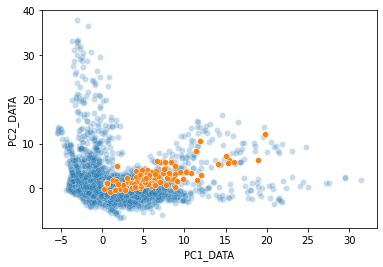

In [174]:
# import working libraries
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


# Drop qualitative columns
data_reduced = catchment_areas_onehot_grouped_clustering_scaled.copy()

# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca = PCA(n_components=2)
pca.fit(data_reduced)

# Transfor the scaled data to the new PCA space
data_reduced = pca.transform(data_reduced)

# Convert to df
data_reduced = pd.DataFrame(data_reduced, columns=['PC1_DATA', 'PC2_DATA'])

# Parse back catchment IDs
data_reduced['CATCHMENT_ID'] = catchment_areas_onehot_grouped['CATCHMENT_ID'].copy()

# Get existing catchment areas
existing_restaurant_catchment_areas = pd.DataFrame(restaurants_hexagons['CATCHMENT_ID'].unique()).rename(columns={0:'CATCHMENT_ID'})

# Assign country
existing_restaurant_catchment_areas['COUNTRY'] = 'GERMANY'

# Parse back country information
data_reduced = data_reduced.merge(existing_restaurant_catchment_areas, how='left', on='CATCHMENT_ID')

# Fill NaN values with remaining country
data_reduced['COUNTRY'] = data_reduced['COUNTRY'].fillna("UNITED KINGDOM")

# Viz
sns.scatterplot(
    data=data_reduced[data_reduced.COUNTRY == "UNITED KINGDOM"], 
    x="PC1_DATA", 
    y="PC2_DATA", 
    alpha=0.25)
sns.scatterplot(
    data=data_reduced[data_reduced.COUNTRY == "GERMANY"], 
    x="PC1_DATA", 
    y="PC2_DATA", 
    alpha=1)

As you can see, we have all datapoints on one graph. In result, it is much easier for us to interpret how our data behaves and what we are dealing with. 
<br>
<br>
Now, ignore the orange dots for a moment and focus on the entire shape of our data. We can see that we have a lot of outliers on the bottom right and upper left. The majority of the data is concentrated in the left corner of our graph. This indicates that we actually have only one large cluster in our data set that seems to share similar properties. That is not suprising as we are analyzing venue categories only.
<br>
<br>
Let's talk about the orange dots. Those represent the data that originates from our existing L'Osteria restaurants. We can see that the majority of this data lies within the large cluster in the bottom left and some of it belongs to the outliers on the bottom right side of the graph.
<br>
<br>
How is this helping us? We can see that there is only one major cluster but at the same time we can observe that the datapoints we are interested in have a clear indication to the right side of our graph. So when we evaluate our model, we should keep this in mind and see whether we managed to catch these datapoints or not. 
<br>
<br>
But our data is now ready and can be parsed to the k-means algorithm, so let's focus on that. The k-means algorithm requires us to pick the number of clusters it is supposed to divide the data into. Luckily, we can use a simple trick to determine which amount of clusters is the best: We will use the "Elbow" method. 
<br>
<br>
The [Elbow](https://predictivehacks.com/k-means-elbow-method-code-for-python/) method is pretty simple but effective. With this approach, you set a range of cluster amounts. For each amount in the range, the algorithm will be trained again. Afterwards, we can analyze the distortions of each run and make our decision based on that:

100%|██████████| 10/10 [00:37<00:00,  3.77s/it]


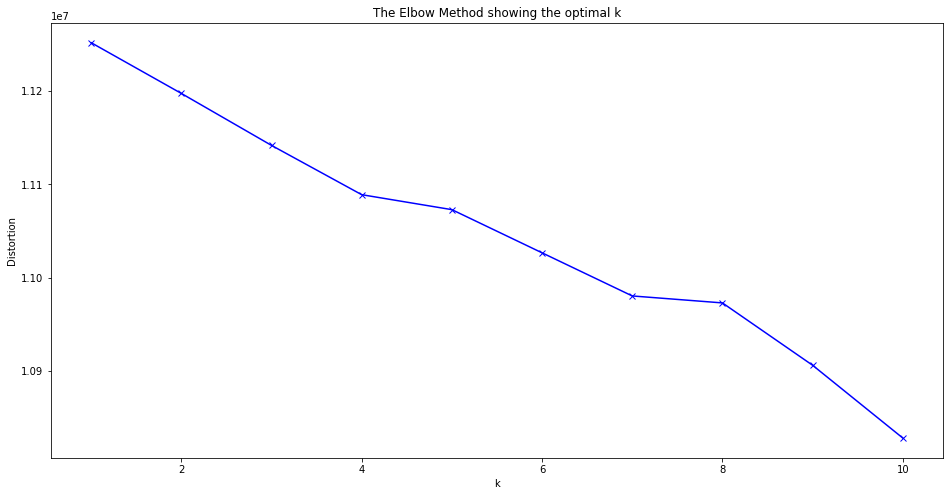

In [175]:
# Importing libraries
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Create variable
distortions = []

# Set range
K = range(1,11)

# Run algorithm on range
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(catchment_areas_onehot_grouped_clustering_scaled)
    distortions.append(kmeanModel.inertia_)

# Viz
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We can see that our Elbow method failed as the grpah shows a more or less linear decline. That is not suprising as our data is very condensed and does not show clear clusters straight away. However, this does not necessarily mean that there are no clusters in our data. It simply means that the k-means algorithm has trouble to identify them. 
<br>
<br>
There are several way to improve the results (e.g. adding different data or further data transformation), however, we will refrain from doing so for now. Our major objective is to build amodel that identifies similarities between existing restaurants in Germany and locations in London to reduce the time needed for manual location scouting. Consequently, if our algorithm can rule out a significant amount of locations in London, we can consider our approach to be successful. 
<br>
<br>
We will therefore start with 3 clusters. Depending on the result, we can add more clusters. Please note that we are adding a random state to our alorithm. This means that the algorithm will reproduce the same results, every time it is run. If you remove the random state, the results will differ as the k-means algorithm is initiated with random centroids. 

In [176]:
from sklearn.cluster import KMeans

# Set number of clusters
kclusters = 3

# Run algorithm
kmeans = KMeans(n_clusters=kclusters, random_state=34).fit(catchment_areas_onehot_grouped_clustering_scaled)

# Insert clusters back into variable
catchment_areas_onehot_grouped_clustering_scaled.insert(0, 'CLUSTER_LABELS', kmeans.labels_)

# Insert catchment IDs back into variable
catchment_areas_onehot_grouped_clustering_scaled['CATCHMENT_ID'] = catchment_areas_onehot_grouped['CATCHMENT_ID'].copy()

# Insert cluster centroids back into variable
centroids = kmeans.cluster_centers_
centroids_x = [i[0] for i in centroids]
centroids_y = [i[1] for i in centroids]
catchment_areas_onehot_grouped_clustering_scaled['CENTROID_X'] = catchment_areas_onehot_grouped_clustering_scaled.CLUSTER_LABELS.map({0:centroids_x[0], 1:centroids_x[1], 2:centroids_x[2]})
catchment_areas_onehot_grouped_clustering_scaled['CENTROID_Y'] = catchment_areas_onehot_grouped_clustering_scaled.CLUSTER_LABELS.map({0:centroids_y[0], 1:centroids_y[1], 2:centroids_y[2]})

# Create new variable
clusters = catchment_areas_onehot_grouped_clustering_scaled.copy()

# Viz
print(clusters.shape)
clusters.head()

(16997, 666)


,CLUSTER_LABELS,ATM,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,...,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,CATCHMENT_ID,CENTROID_X,CENTROID_Y
0,2,-0.051770,-0.10452,-0.033453,-0.03411,-0.063112,-0.026101,-0.062013,-0.121017,-0.177632,...,-0.240396,-0.059753,-0.058375,-0.086131,-0.155194,-0.051452,-0.085737,1a8f3128-2730-11ec-a9a8-0433c21e09d2,0.104846,0.180444
1,2,-0.051770,-0.10452,-0.033453,-0.03411,-0.063112,-0.026101,-0.062013,-0.121017,-0.177632,...,-0.240396,-0.059753,-0.058375,-0.086131,-0.155194,-0.051452,-0.085737,1a8f3129-2730-11ec-ab80-0433c21e09d2,0.104846,0.180444
2,2,-0.051770,-0.10452,-0.033453,-0.03411,-0.063112,-0.026101,-0.062013,-0.121017,-0.177632,...,-0.240396,-0.059753,-0.058375,-0.086131,-0.155194,-0.051452,-0.085737,1a8f312a-2730-11ec-8ace-0433c21e09d2,0.104846,0.180444
3,2,-0.051770,-0.10452,-0.033453,-0.03411,-0.063112,-0.026101,-0.062013,-0.121017,-0.177632,...,-0.240396,-0.059753,-0.058375,-0.086131,-0.155194,-0.051452,-0.085737,1a8f312b-2730-11ec-87a1-0433c21e09d2,0.104846,0.180444
4,2,10.679138,-0.10452,-0.033453,-0.03411,-0.063112,-0.026101,-0.062013,-0.121017,-0.177632,...,-0.240396,-0.059753,-0.058375,-0.086131,-0.155194,-0.051452,-0.085737,1a8f312c-2730-11ec-9e91-0433c21e09d2,0.104846,0.180444


# THE RESULTS
In this section we will have a closer look at the results of our clustering. As we have over 600 dimensions to deal with, we will first reduce the dimensions to two by using PCA. This way we can plot our data the same way as we did before.

<AxesSubplot:xlabel='PC1_DATA', ylabel='PC2_DATA'>

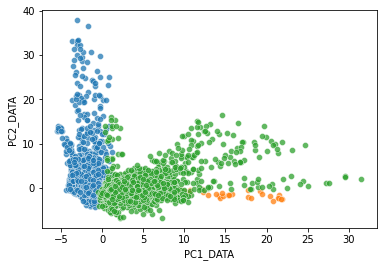

In [177]:
# Drop qualitative columns
clusters_reduced = clusters.drop(columns=[
    'CATCHMENT_ID',
    'CLUSTER_LABELS',
    'CENTROID_X',
    'CENTROID_Y'])

# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca = PCA(n_components=2)
pca.fit(clusters_reduced)

# Transfor the scaled data to the new PCA space
clusters_reduced = pca.transform(clusters_reduced)

# Convert to df
clusters_reduced = pd.DataFrame(clusters_reduced, columns=['PC1_DATA', 'PC2_DATA'])

# Add cluster id
clusters_reduced['CLUSTER_LABELS'] = clusters['CLUSTER_LABELS'].copy()

# Set number of colours
cluster_amount = clusters_reduced['CLUSTER_LABELS'].nunique()

# Get colours
palette = sns.color_palette(None, cluster_amount)

# Plot
sns.scatterplot(
    data=clusters_reduced[clusters_reduced.CLUSTER_LABELS == 0], 
    x="PC1_DATA", 
    y="PC2_DATA", 
    palette=palette,
    alpha=0.75)
sns.scatterplot(
    data=clusters_reduced[clusters_reduced.CLUSTER_LABELS == 1], 
    x="PC1_DATA", 
    y="PC2_DATA", 
    palette=palette,
    alpha=0.75)
sns.scatterplot(
    data=clusters_reduced[clusters_reduced.CLUSTER_LABELS == 2], 
    x="PC1_DATA", 
    y="PC2_DATA",
    palette=palette,
    alpha=0.75)

We can see that the algorithm has successfully divided our data into the desired amount of clusters. We can clearly see that the outliers as well as the large data cloud in the middle have been divided into their own clusters. However, we can also see that there is some overlapping of the clusters. So let us look at each cluster individually: 

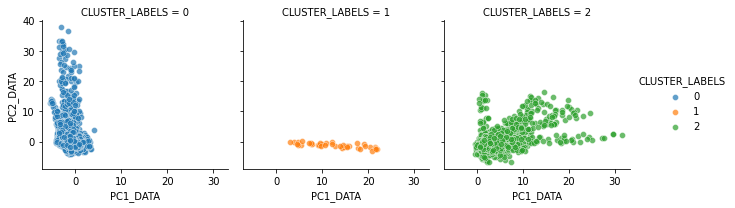

In [178]:
# Plot
g = sns.FacetGrid(clusters_reduced, col="CLUSTER_LABELS", hue="CLUSTER_LABELS")
g.map(sns.scatterplot, "PC1_DATA", "PC2_DATA", alpha=.7)
g.add_legend()

We can see that we have two major clusters (0 and 2) as well as one small cluster (1). Cluster 0 and 2 are clearly seperated while cluster 1 seems to be rather random. On a first look, we can assume that cluster 2 is a pretty good fit for our existing restaurants. To confirm this hypothisis, we can map the restaurant data onto the different clusters:

<AxesSubplot:xlabel='PC1_DATA', ylabel='PC2_DATA'>

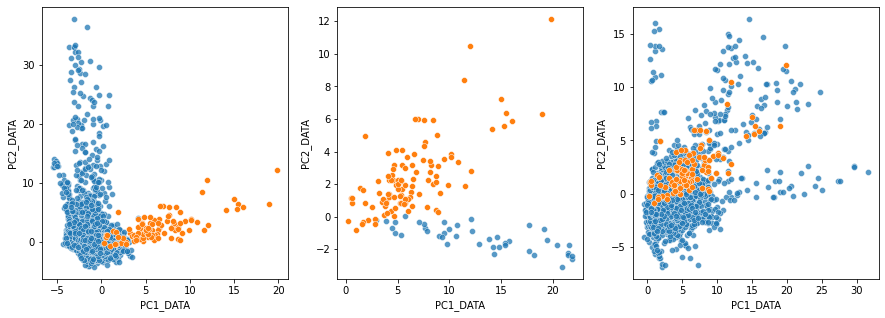

In [179]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))

# Map against cluster 0
sns.scatterplot(
    data=clusters_reduced[clusters_reduced.CLUSTER_LABELS == 0], 
    x="PC1_DATA", 
    y="PC2_DATA", 
    palette=palette,
    alpha=0.75, 
    ax=axs[0])
sns.scatterplot(
    data=data_reduced[data_reduced.COUNTRY == "GERMANY"], 
    x="PC1_DATA", 
    y="PC2_DATA", 
    alpha=1, 
    ax=axs[0])

# Map against cluster 1
sns.scatterplot(
    data=clusters_reduced[clusters_reduced.CLUSTER_LABELS == 1], 
    x="PC1_DATA", 
    y="PC2_DATA", 
    palette=palette,
    alpha=0.75, 
    ax=axs[1])
sns.scatterplot(
    data=data_reduced[data_reduced.COUNTRY == "GERMANY"], 
    x="PC1_DATA", 
    y="PC2_DATA", 
    alpha=1, 
    ax=axs[1])

# Map against cluster 1
sns.scatterplot(
    data=clusters_reduced[clusters_reduced.CLUSTER_LABELS == 2], 
    x="PC1_DATA", 
    y="PC2_DATA", 
    palette=palette,
    alpha=0.75, 
    ax=axs[2])
sns.scatterplot(
    data=data_reduced[data_reduced.COUNTRY == "GERMANY"], 
    x="PC1_DATA", 
    y="PC2_DATA", 
    alpha=1, 
    ax=axs[2])

The above graph shows us how the data points of our existing restaurants map against each cluster. We can see that cluster 0 has only few similarities as only a small amount of data points are overlapping. Cluster 1 is clearly a bad fit as it shows nearly no overlay at all. Finally, cluster 2 is clearly the best fit, covering all of our existing datapoints. However, we should note that cluster 2 is a little bit too large and shows additional outliers in a different direction than our existing restaurant data. This indicates that an additional clustering of this particular cluster could lead to even better results. However, for now we will leave it be as time and ressources are scarce. ;-) 
<br>
<br>
The results of our experiment confirm that cluster 0 and 1 have only little or nearly no overlay with data points from existing L'Osteria restaurants. Consequently, we will drop all catchment areas from these clusters and focus on cluster 2 in the next step of our analysis.
<br>
<br>
As we have now determined that cluster 2 has the most common features with our existing restaurants, let us have a look what makes this cluster so special. To understand its properties better, we can vizualize all features at ones and analyze the most common features. 
<br>
<br>
To do so, we need to conduct two steps. First, we need to isolate our cluster 2 and get back the initial dataset before we applied PCA and transformation. This way we will be able to interpret the results better. Second, we need to exclude all features that show a 0 in their column. In result, we will exclude all venue categories that are not relevant for the chosen cluster and thus (hopefully) decreasing the amount of dimensions (it would be a little difficult to graph over 600 features at once).  

In [217]:
# Define chosen cluster
chosen_cluster = 2

# Get untransformed data
target_cluster = catchment_areas_onehot_grouped_clustering.copy()

# Get catchment ID
target_cluster['CATCHMENT_ID'] = catchment_areas_onehot_grouped['CATCHMENT_ID'].copy()

# Get country information
target_cluster['COUNTRY'] = data_reduced['COUNTRY'].copy()

# Get cluster labels
target_cluster['CLUSTER_LABELS'] = clusters['CLUSTER_LABELS'].copy()

# Isolate chosen cluster
target_cluster = target_cluster[(target_cluster['CLUSTER_LABELS'] == chosen_cluster)].copy()

# Drop columns with 0 values
target_cluster = target_cluster.loc[:, (target_cluster.sum(axis=0) != 0)]

# Viz
print("Clusters included: {}".format(target_cluster['CLUSTER_LABELS'].nunique()))
print("Cluster value: {}".format(chosen_cluster))
print(target_cluster.shape)
target_cluster.head()

Clusters included: 1
Cluster value: 2
(3974, 638)


,ATM,Accessories Store,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Gate,Airport Lounge,...,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,CATCHMENT_ID,COUNTRY,CLUSTER_LABELS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1a8f3128-2730-11ec-a9a8-0433c21e09d2,GERMANY,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1a8f3129-2730-11ec-ab80-0433c21e09d2,GERMANY,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1a8f312a-2730-11ec-8ace-0433c21e09d2,GERMANY,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1a8f312b-2730-11ec-87a1-0433c21e09d2,GERMANY,2
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1a8f312c-2730-11ec-9e91-0433c21e09d2,GERMANY,2


As we can see, we unfortunately still have over 600 dimensions to deal with. To conquer this problem, we will have to introduce thresholds that exclude columns with smaller entries. We can define these treshholds by analyzing the total column sums: 

In [241]:
# Calculate sums
total = pd.DataFrame(target_cluster.sum(axis=0)).T.drop(columns=['CATCHMENT_ID', 'COUNTRY', 'CLUSTER_LABELS']).T

# Convert to integers
total = total.apply(pd.to_numeric)

# Analyze
total.describe(include='all')

,0
count,635.000000
mean,767.151181
std,2371.801459
min,1.000000
25%,37.000000
50%,152.000000
75%,593.500000
max,43174.000000


We can see that the majority of our dataset lies around the median of 152. So let us set our treshholds between something around that figure (e.g. 125 and 175). We will also vizualize our results stright away to help us with interpreting them.

In [291]:
# Import plotly
import plotly.express as px

# Drop string columns
target_cluster_majority = target_cluster.drop(columns=['CATCHMENT_ID', 'COUNTRY', 'CLUSTER_LABELS'])

# Filter based on threshholds
target_cluster_majority = target_cluster_majority.loc[:, (target_cluster_majority.sum() >= 125) & (target_cluster_majority.sum() <= 175) ]

# Sum data
target_cluster_majority = pd.DataFrame(target_cluster_majority.sum(axis=0)).reset_index().sort_values(by=0, ascending=True)

# Viz
fig = px.bar(
    target_cluster_majority,
    x=0, 
    y='index', 
    orientation='h',
    height=800)
fig.show()


In [294]:
# Import plotly
import plotly.express as px

# Drop string columns
target_cluster_outliers = target_cluster.drop(columns=['CATCHMENT_ID', 'COUNTRY', 'CLUSTER_LABELS'])

# Filter based on threshholds
target_cluster_outliers = target_cluster_outliers.loc[:, (target_cluster_outliers.sum() >= 3000)]

# Sum data
target_cluster_outliers = pd.DataFrame(target_cluster_outliers.sum(axis=0)).reset_index().sort_values(by=0, ascending=True)

# Viz
fig = px.bar(
    target_cluster_outliers,
    x=0, 
    y='index', 
    orientation='h',
    height=800)
fig.show()


In [109]:
# # Get centroids for existing restaurants
# clusters_reduced_centers = clusters[['CENTROID_X', 'CENTROID_Y']]

# # Perform PCA
# pca = PCA(n_components=2)
# pca.fit(clusters_reduced_centers)

# # Get values
# centres_reduced = pca.transform(clusters_reduced_centers)

# # Convert to df
# centres_reduced = pd.DataFrame(centres_reduced, columns=['PC1_CENTROID', 'PC2_CENTROID'])

# # Get labels
# centres_reduced['CLUSTER_LABELS'] = clusters['CLUSTER_LABELS'].copy()

# # Get uniques
# centres_reduced = centres_reduced.drop_duplicates()

# # Viz
# print(centres_reduced.shape)
# centres_reduced.head()

In [110]:
# # Get centroids for existing restaurants
# centres_reduced = clusters[['CENTROID_X', 'CENTROID_Y']].copy()

# centres_reduced['CLUSTER_LABELS'] = clusters['CLUSTER_LABELS'].copy()

# #Get uniques
# centres_reduced = centres_reduced.drop_duplicates()

# # Viz
# print(centres_reduced.shape)
# centres_reduced.head()

Wounderful! Now let us do the same with the centroids so that we can map everything on one chart.

# THE DISCUSSION

# THE CONCLUSION